# Sensitivity analysis of the ichigami function with the old and new codes. Comparison.
### These codes will also be good for tuning our class to support aggregated decomposed processes. 

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import PureBeamExample as pbe
import spsa


Bad key "text.kerning_factor" on line 4 in
/home/simady/anaconda/envs/stochastic_field_env/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
ot.RandomGenerator.SetSeed(0)
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

def gMod(X):
    if isinstance(X[0], ot.ProcessSample):
        print('was process sample')
        X[0] = [X[0][i][0] for i in range(X[0].getSize())]
        X[1] = [X[1][i][0] for i in range(X[1].getSize())]
        X[2] = [X[2][i][0] for i in range(X[2].getSize())]
    X = np.stack([np.asarray([x[0] for x in X[0]]),np.asarray([x[0] for x in X[1]]),np.asarray([x[0] for x in X[2]])]).T
    return g(X)
#Here the function is defined
dimension = 1
NElem = [100]
mesher = ot.IntervalMesher(NElem)
lowerBound = [0] #mm
upperBound = [1000] #mm
interval = ot.Interval(lowerBound,upperBound)
mesh = mesher.build(interval)

In [3]:
uniform0 = ot.Uniform(-np.pi, np.pi)
uniform1 = ot.Uniform(-np.pi, np.pi)
uniform2 = ot.Uniform(-np.pi, np.pi)
combinedUniform = ot.ComposedDistribution([uniform0, uniform1, uniform2])

In [4]:
def distributionOnMesh(distribution, mesh):
    '''Function to transform a scalar distribution into 
    a constant process defined over a mesh
    '''
    basis = ot.Basis([ot.SymbolicFunction(['x'],['1'])])
    distributionOnMesh = ot.FunctionalBasisProcess(distribution, basis, mesh)
    distributionOnMesh.setName(distribution.getName())
    return distributionOnMesh

In [5]:
uniform0_as_const_process = distributionOnMesh(uniform0, mesh)
uniform1_as_const_process = distributionOnMesh(uniform1, mesh)
uniform2_as_const_process = distributionOnMesh(uniform2, mesh)

algorithm0 = ot.KarhunenLoeveP1Algorithm(mesh, uniform0_as_const_process.getCovarianceModel(), 1e-6)
algorithm0.run()
uniform0_klresults = algorithm0.getResult()

algorithm0 = ot.KarhunenLoeveP1Algorithm(mesh, uniform1_as_const_process.getCovarianceModel(), 1e-6)
algorithm0.run()
uniform1_klresults = algorithm0.getResult()

algorithm0 = ot.KarhunenLoeveP1Algorithm(mesh, uniform2_as_const_process.getCovarianceModel(), 1e-6)
algorithm0.run()
uniform2_klresults = algorithm0.getResult()


In [6]:
import numpy as np
_abc = ['A','B','C','D','E','F','G']

def all_same(items=None):
    #Checks if all items of a list are the same
    return all(x == items[0] for x in items)

def isValidSobolIndicesExperiment(sample_like, size, second_order = False):
    try :
        sample = np.asarray(sample_like)
    except :
        print('Could not convert sample to numpy array')
        raise TypeError
    N = sample.shape[0]
    dim = sample.shape[1]
    Y_A = sample[:size]
    Y_B = sample[size:2*size]
    N_indice = int(N/size - 2)
    assert N%size==0,"wrong sample size"
    print('Simplified view of the sobol indices experiments structure')
    print('There are {} dimensions and {} sobol indices to calculate'.format(dim, N_indice))
    assert np.where(Y_A==Y_B,True,False).any() == False     
    tot_lines = list()
    try : 
        for i in range(N_indice+2):
            Y_E = sample[i*size:(i+1)*size]
            tot_cols = [True]*dim
            col_where_A = list(set(np.argwhere(Y_A==Y_E)[:,1]))
            line_where_A = list(set(np.argwhere(Y_A==Y_E)[:,0]))
            if len(line_where_A)==size : OK = True
            for co in col_where_A :
                tot_cols[co] = False
            if OK : 
                if len(col_where_A)==dim and all(tot_cols):
                    sl = ['A_'+str(j) for j in range(dim)]
                elif len(col_where_A)==0 and all_same(tot_cols):
                    sl = ['B_'+str(j) for j in range(dim)]
                else :
                    sl = ['B_'+str(j) for j in range(dim)]
                    for k in range(len(col_where_A)):
                        sl[col_where_A[k]] = 'A_'+str(col_where_A[k])
                l = "  ,    ".join(sl)
                l = '    '+l
            if not OK :
                print('Error')
                return False
            tot_lines.append(l)
        repres = ' \n\n'.join(tot_lines)
        repres = '\n'+repres
        print(repres) 
        return True
    except :
        return False 

In [7]:
import KarhunenLoeveFieldSensitivity as klfs

In [8]:
aggre_res = klfs.AggregatedKarhunenLoeveResults([uniform0, uniform1, uniform2])

The process names are not unique.
Using generic name. 
Old name was Uniform, new one is X_0
Old name was Uniform, new one is X_1
Old name was Uniform, new one is X_2


In [9]:
FUNC = klfs.KarhunenLoeveGeneralizedFunctionWrapper(
                                AggregatedKarhunenLoeveResults = aggre_res,
                                func        = gMod, 
                                func_sample = gMod,
                                n_outputs   = 1)

In [10]:
nModes = aggre_res.getSizeModes()  # the number of elements in the input vector of our KL wrapped model
randNormVect = ot.ComposedDistribution([ot.Normal()] * nModes)

def getSobolExperiment(aggrkl, size, seed=149284, secondOrder = False):
    ot.RandomGenerator.SetSeed(seed)    
    experiment = klfs.KarhunenLoeveSobolIndicesExperiment(aggrkl, size, secondOrder)
    sobolExp = experiment.generate()
    return sobolExp, experiment

sobolExp, exper = getSobolExperiment(aggre_res, 1000)

composedUniformInput = ot.SobolIndicesExperiment(combinedUniform, 1000)
inputComposed = composedUniformInput.generate()

valid = isValidSobolIndicesExperiment(sobolExp, 1000)
assert valid
valid = isValidSobolIndicesExperiment(inputComposed, 1000)
assert valid
output_base = g(inputComposed)
output = FUNC(sobolExp)


Samples A and B of size 1000 and dimension 3
Experiment of size 5000 and dimension 3
Simplified view of the sobol indices experiments structure
There are 3 dimensions and 3 sobol indices to calculate

    A_0  ,    A_1  ,    A_2 

    B_0  ,    B_1  ,    B_2 

    B_0  ,    A_1  ,    A_2 

    A_0  ,    B_1  ,    A_2 

    A_0  ,    A_1  ,    B_2
Simplified view of the sobol indices experiments structure
There are 3 dimensions and 3 sobol indices to calculate

    A_0  ,    A_1  ,    A_2 

    B_0  ,    B_1  ,    B_2 

    B_0  ,    A_1  ,    A_2 

    A_0  ,    B_1  ,    A_2 

    A_0  ,    A_1  ,    B_2
Lifting as process sample
was process sample
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element 0 of the output tuple returns elements of type Sample of dimension 1


In [11]:
my_output = output[0].computeVariance()
base_output = output_base.computeVariance()
print(my_output, base_output)
my_input_var = sobolExp.computeVariance()
base_input_var = inputComposed.computeVariance()
print(my_input_var, base_input_var)

Y = aggre_res.liftAsProcessSample(sobolExp)
Y[0] = [Y[0][i].getMax()[0] for i in range(Y[0].getSize())]
Y[1] = [Y[1][i].getMax()[0] for i in range(Y[1].getSize())]
Y[2] = [Y[2][i].getMax()[0] for i in range(Y[2].getSize())]
Y = ot.Sample(np.stack(Y).T)
lifted_input_var = Y.computeVariance()
print(lifted_input_var)
print('min max uniform:',inputComposed.getMin(), inputComposed.getMax())
print('min max lifted:',Y.getMin(), Y.getMax())

[13.7451] [14.7256]
[1.02452,0.958281,1.01427] [3.23718,3.24071,3.34305]
Lifting as process sample
[3.35886,3.20622,3.32624]
min max uniform: [-3.13857,-3.13984,-3.13143] [3.14113,3.14136,3.13751]
min max lifted: [-3.13996,-3.13835,-3.13843] [3.13711,3.13851,3.14079]


In [12]:
sensi = klfs.SobolKarhunenLoeveFieldSensitivityAlgorithm()
sensi.setDesign(sobolExp, output, 1000)

size initialized 5000
if you also pass the data to compute it
Otherwise, the behavior will be unreliable

Means is
 [3.6169]
design_elem size, dim 5000 1
There are 3 indices to get for 1 outputs with dimensions 1 each.
Description all same? [X_0_0,X_1_0,X_2_0]
SobolIndicesName ['X_0_', 'X_1_', 'X_2_']
Input Description is, ['X_0_', 'X_1_', 'X_2_']


In [13]:
sensi.getFirstOrderIndices()

Solving...
 size of samples:  5000
 number of indices to get 3


[[class=Point name=Sobol_Y_0_X_0_ dimension=1 values=[0.30924],
  class=Point name=Sobol_Y_0_X_1_ dimension=1 values=[0.453793],
  class=Point name=Sobol_Y_0_X_2_ dimension=1 values=[-0.0612508]]]

In [14]:
sensi.getTotalOrderIndices()

[[class=Point name=TotalOrderSobol_Y_0_X_0_ dimension=1 values=[0.564247],
  class=Point name=TotalOrderSobol_Y_0_X_1_ dimension=1 values=[0.452711],
  class=Point name=TotalOrderSobol_Y_0_X_2_ dimension=1 values=[0.220581]]]

In [15]:
Y_ = aggre_res.liftAsProcessSample(sobolExp)
Y = Y_[:]
Y_[0] = [Y[0][i].getMax()[0] for i in range(Y[0].getSize())]
Y_[1] = [Y[1][i].getMax()[0] for i in range(Y[1].getSize())]
Y_[2] = [Y[2][i].getMax()[0] for i in range(Y[2].getSize())]
Y_ = np.stack(Y_).T

Lifting as process sample


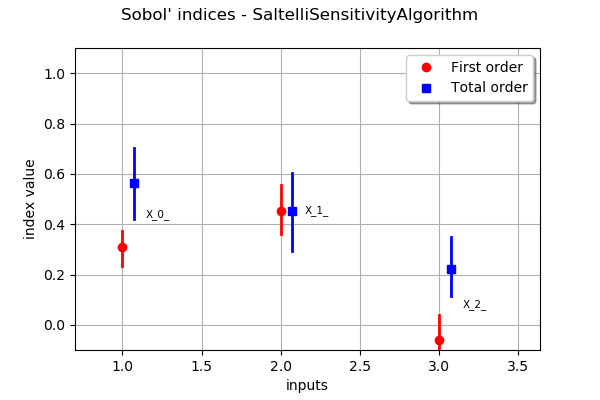

In [16]:
sensi.__results__[0].draw()


In [17]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(Y_, out2[0], 1000)

NameError: name 'out2' is not defined

In [18]:
sensitivityAnalysis.draw()

NameError: name 'sensitivityAnalysis' is not defined

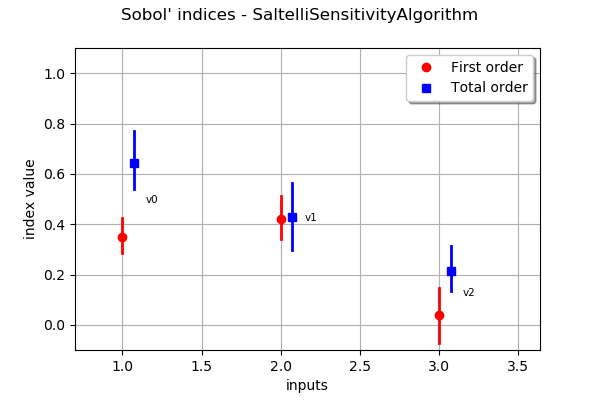

In [19]:
sensitivityBase = ot.SaltelliSensitivityAlgorithm(Y_, output_base, 1000)
sensitivityBase.draw()